In [73]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass, asdict
import csv
import json
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Optional
from datetime import datetime
from main import sample_episode
import numpy as np
import matplotlib.pyplot as plt

# from scipy.special import theta
import numpy as np

# --- Jacobi theta3 helper: theta(3, z, q) ---
try:
    # If your SciPy has it, this will work in your environment
    from scipy.special import theta as _theta

    def theta3(z, q):
        # SciPy version: vectorized
        return _theta(3, z, q)

except Exception:
    # Fallback: mpmath (scalar; we convert to float)
    import mpmath as mp

    def theta3(z, q):
        return float(mp.jtheta(3, z, q))


In [74]:
def heat_kernel_S1(t, x, y, wrap=True):
    """
    Heat kernel on S^1 using theta3.
    x,y are angles in radians (typically in [0, 2π)).
    wrap=True wraps differences into (-π, π] for numerical stability.
    """
    d = x - y
    if wrap:
        d = (d + np.pi) % (2 * np.pi) - np.pi  # wrap to (-π, π]
    q = np.exp(-t)
    return (1 / (2 * np.pi)) * theta3(d / 2, q)


def heat_kernel_torus_2d(t, x_vec, y_vec, wrap=True):
    """
    Product kernel on S^1 x S^1 (2D torus).
    x_vec, y_vec are length-2 arrays: [angle1, angle2].
    """
    return heat_kernel_S1(t, x_vec[0], y_vec[0], wrap=wrap) * \
           heat_kernel_S1(t, x_vec[1], y_vec[1], wrap=wrap)




def gram_matrix_heat_torus_2d(X, t, wrap=True):
    """
    Build Gram matrix K where K[i,j] = heat_kernel_torus_2d(t, X[i], X[j]).
    X: shape (n, 2)
    """
    X = np.asarray(X, dtype=float)
    if X.ndim != 2 or X.shape[1] != 2:
        raise ValueError("X must have shape (n, 2) for 2D inputs.")

    n = X.shape[0]
    K = np.empty((n, n), dtype=float)

    # Fill symmetrically
    for i in range(n):
        for j in range(i, n):
            v = heat_kernel_torus_2d(t, X[i], X[j], wrap=wrap)
            K[i, j] = v
            K[j, i] = v
    return K


def solve_alphas(K, y, lam):
    """
    Solve (K + lam I) alpha = y without forming an explicit inverse.
    """
    K = np.asarray(K, dtype=float)
    y = np.asarray(y, dtype=float).reshape(-1)
    n = K.shape[0]
    if K.shape != (n, n):
        raise ValueError("K must be square.")
    if y.shape[0] != n:
        raise ValueError("y must have length n.")
    if lam <= 0:
        raise ValueError("lam should be > 0 for stable regularization.")

    # A = K + lam * np.eye(n)
    alpha = np.linalg.solve(K @ K + lam * K, K @ y)

    # # Cholesky is best when A is SPD (lam>0 typically ensures this)
    # try:
    #     L = np.linalg.cholesky(A)
    #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    # except np.linalg.LinAlgError:
    #     # Fallback if numerical issues arise
    #     alpha = np.linalg.solve(A, y)

    return alpha


def fit_kernel_machine_heat_torus(X, y, t, lam, wrap=True):
    """
    Convenience: compute Gram matrix + alpha.
    """
    K = gram_matrix_heat_torus_2d(X, t=t, wrap=wrap)
    alpha = solve_alphas(K, y, lam=lam)
    return K, alpha

def predict_heat_torus(X_train, alpha, X_test, t, wrap=True):
    """
    f(x) = sum_i alpha_i k(x, x_i)
    """
    X_train = np.asarray(X_train, dtype=float)
    X_test  = np.asarray(X_test, dtype=float)
    alpha   = np.asarray(alpha, dtype=float).reshape(-1)

    n = X_train.shape[0]
    if alpha.shape[0] != n:
        raise ValueError("alpha length must match number of training points.")

    yhat = np.empty(X_test.shape[0], dtype=float)
    for m, x in enumerate(X_test):
        s = 0.0
        for i in range(n):
            s += alpha[i] * heat_kernel_torus_2d(t, x, X_train[i], wrap=wrap)
        yhat[m] = s
    return yhat

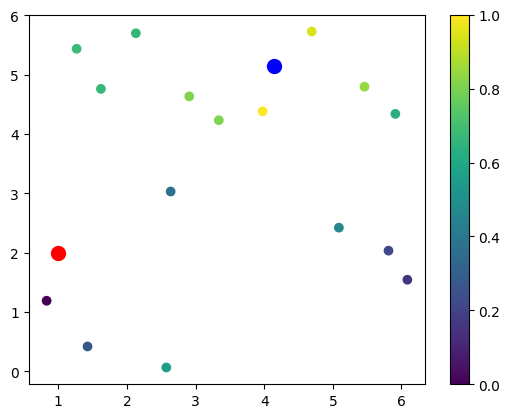

/tmp/ipykernel_15502/2031948583.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  this_vals[rep] = min


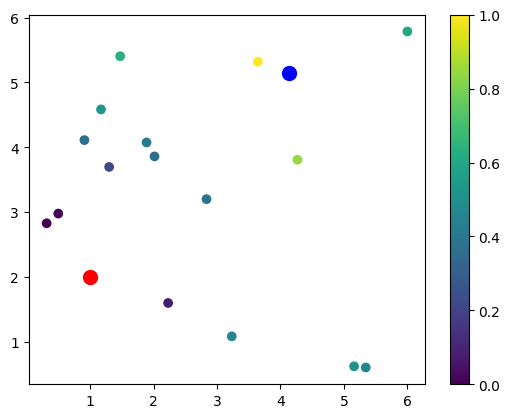

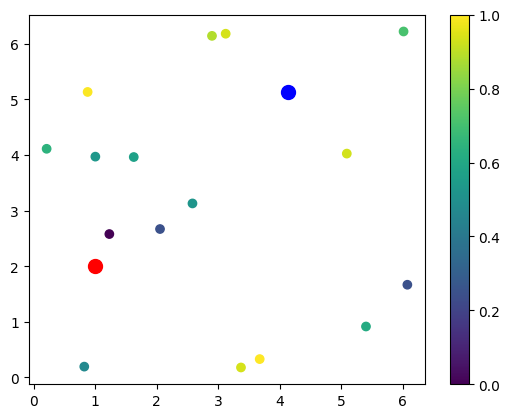

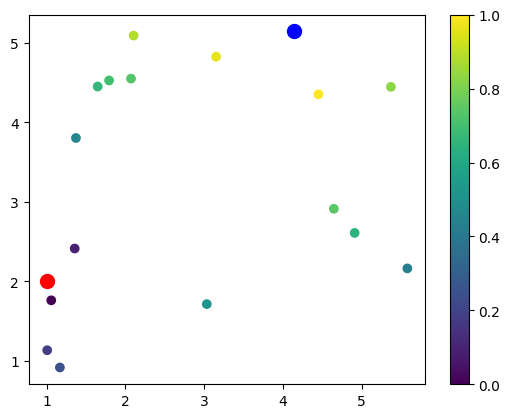

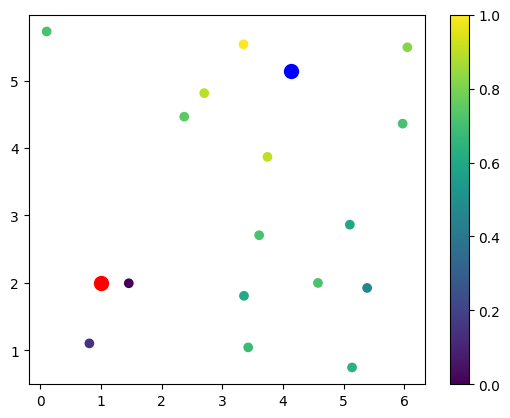

K_context:16   Mean error over 5 episodes: 0.034201608615622485 ± 0.031209844687632837


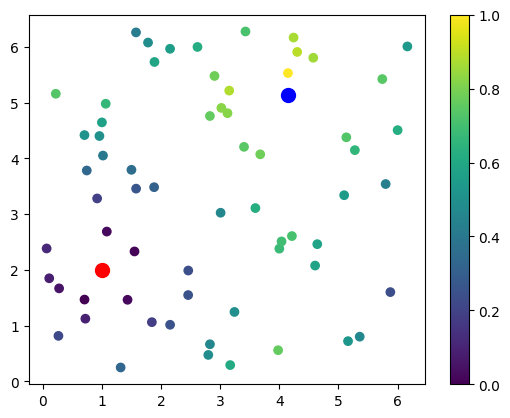

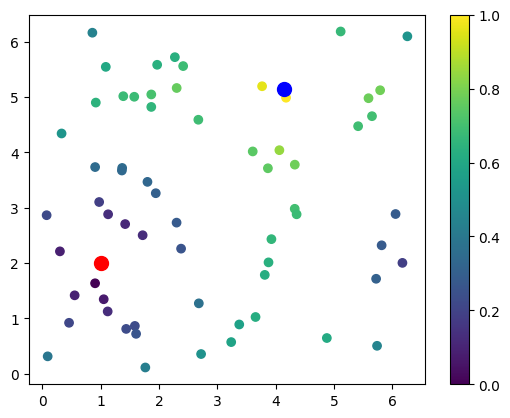

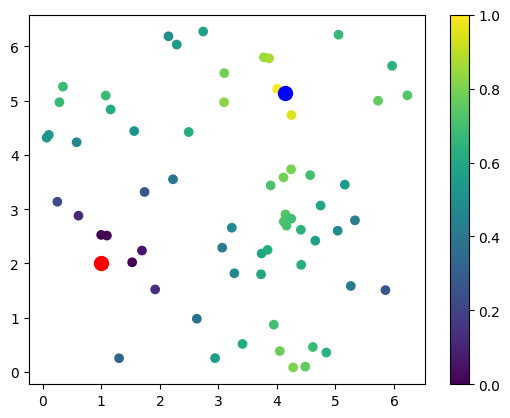

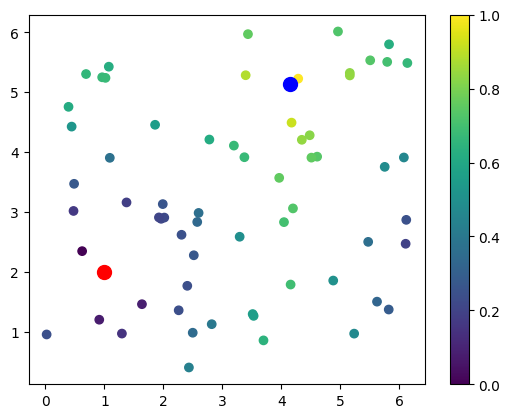

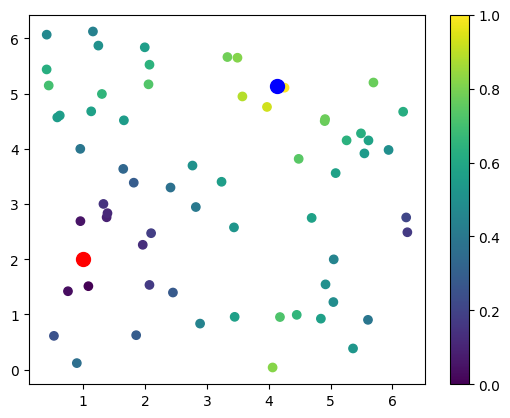

K_context:64   Mean error over 5 episodes: 0.05054101492273137 ± 0.05977900048361626


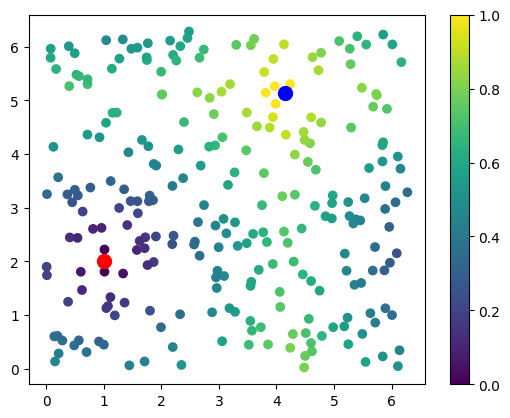

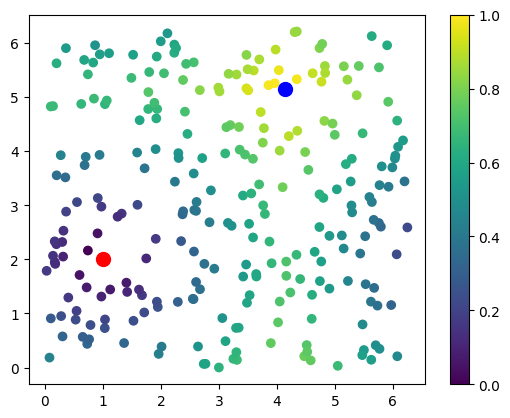

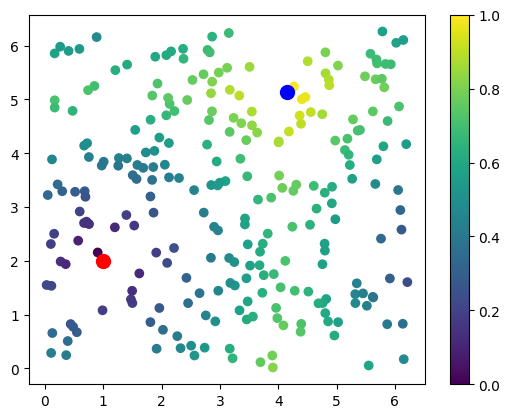

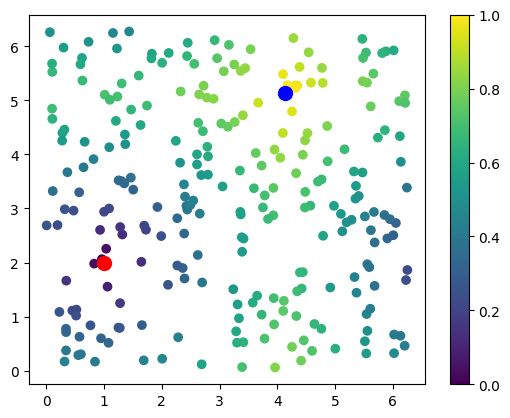

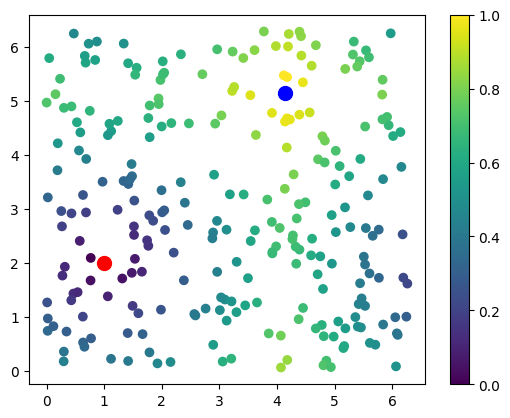

K_context:256   Mean error over 5 episodes: 0.03217974172020853 ± 0.05293293860130367


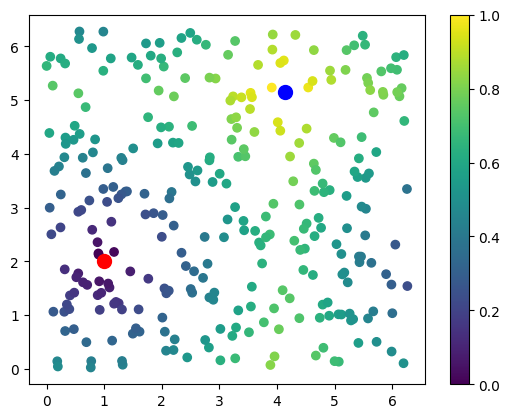

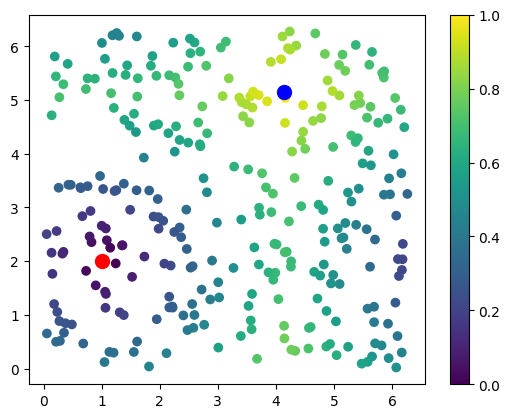

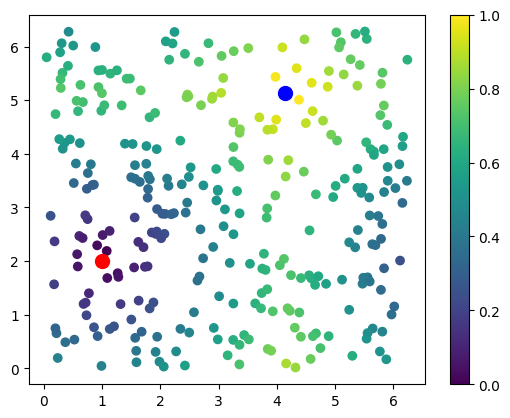

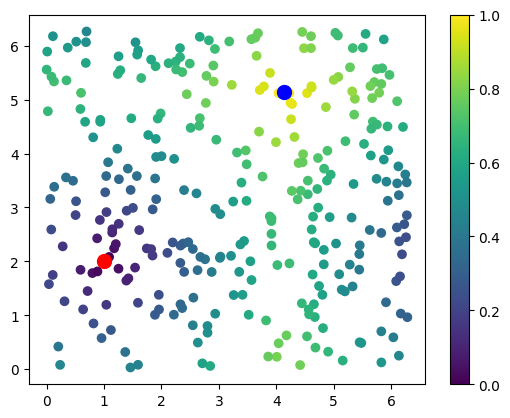

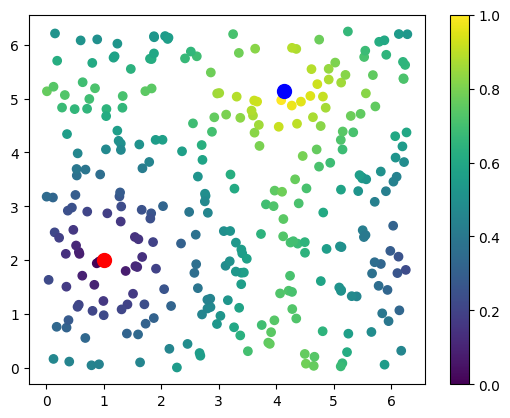

K_context:300   Mean error over 5 episodes: 0.3121183306223792 ± 0.2883789343128402


In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

p = torch.tensor([1.0, 2.0], device=device)
# t = 1

# for Ks in np.linspace(1, K_context, 8):
#     K_tilde = int(Ks)  # downsampled K
#     # t_tilde = t * (1 + K_tilde / K_context)**2  # scale time accordingly
#     t_tilde = t
#     # print(t, t_tilde, K_context, K_tilde)
#     X = tokens.cpu().numpy()[0,0:K_tilde,0:2]  # (K,2)
#     y = tokens.cpu().numpy()[0,0:K_tilde,2]  # (K,2)

#     X_test = tokens.cpu().numpy()[0,-2:-1,0:2]
#     # X_test = tokens.cpu().numpy()[0,0:1,0:2]

#     K, alpha = fit_kernel_machine_heat_torus(X, y, t=t_tilde, lam=1e-4)
#     y_pred = predict_heat_torus(X, alpha, X_test, t=t_tilde)
#     print(f"y_pred:{y_pred.item()}, y:{y_q.cpu().numpy()}, t_tilde:{t_tilde}, K_tilde:{K_tilde}   error {np.abs(y_pred - y_q.cpu().numpy())}")
  
batch_size = 1
num_episodes = 5
context_lengths = [16, 64,256, 300]
means = np.array([])
stds = np.array([])

for K_context in context_lengths:    
    this_vals = np.zeros(num_episodes)
    for rep in range(num_episodes):  # multiple samples to average over
        min = 100

        tokens, y_q = sample_episode(batch_size, K_context, p, device)
        plot_episode(tokens, p, K_context)
        plt.show()

        y_q = torch.exp(-y_q**2)
        # Test various (t_tilde, lam_tilde) combinations
        for t_tilde in [1/K_context]:
            for lam_tilde in [1e-2,0.1]:

                X = tokens.cpu().numpy()[0,0:K_context,0:2]  # (K,2)
                y = tokens.cpu().numpy()[0,0:K_context,2]  # (K,2)
                y = np.exp(-y**2)
                X_test = tokens.cpu().numpy()[0,-2:-1,0:2]
                # X_test = tokens.cpu().numpy()[0,0:1,0:2]
                try :
                    K, alpha = fit_kernel_machine_heat_torus(X, y, t=t_tilde, lam=lam_tilde)
                    y_pred = predict_heat_torus(X, alpha, X_test, t=t_tilde)
                    if np.abs(y_pred - y_q.cpu().numpy()) < min:
                        min = np.abs(y_pred - y_q.cpu().numpy())
                    # print(f"y_pred:{y_pred.item()}, y:{y_q.cpu().numpy()}, t_tilde:{t_tilde}, lam_tilde:{lam_tilde}   error {np.abs(y_pred - y_q.cpu().numpy())}")

                except np.linalg.LinAlgError:
                    pass
                    # print(f"LinAlgError for t_tilde:{t_tilde}, lam_tilde:{lam_tilde}")      
        # Keep track of minimum error across hyperparameters  
        # print(f"Minimum error achieved: {min}")
        this_vals[rep] = min
    mean_error = np.mean(this_vals)
    std_error = np.std(this_vals)
    means = np.append(means, mean_error)
    stds = np.append(stds, std_error)
    print(f"K_context:{K_context}   Mean error over {num_episodes} episodes: {mean_error} ± {std_error}")
    


In [ ]:
context_size = 1000
tokens, y_q  = sample_episode(batch_size, context_size, p, device)

In [ ]:
def plot_episode(tokens, p, context_size):
    points, dists = tokens[0, :context_size, :2].cpu().detach().numpy(),  tokens[0, :context_size, 2].cpu().detach().numpy()
    origin_pt = p.cpu().numpy()
    plt.scatter(points[:,0], points[:,1], c=dists)
    plt.scatter([origin_pt[0]], [origin_pt[1]], color='red', s=100)
    plt.scatter([np.pi + origin_pt[0]], [np.pi + origin_pt[1]], color='blue', s=100)
    plt.colorbar()

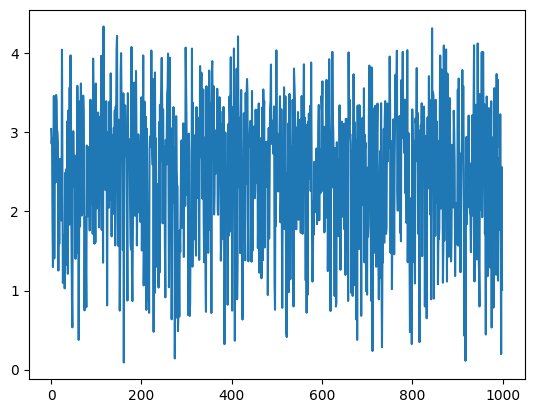

In [ ]:
plt.plot(dists)

In [ ]:
def kernel_behaviour_near_origin(origin, points, t, wrap=True):
    kernel_vals = []
    for point in points:
        v = heat_kernel_torus_2d(t, origin, point, wrap=wrap)
        kernel_vals.append(v)
    return np.asarray(kernel_vals)

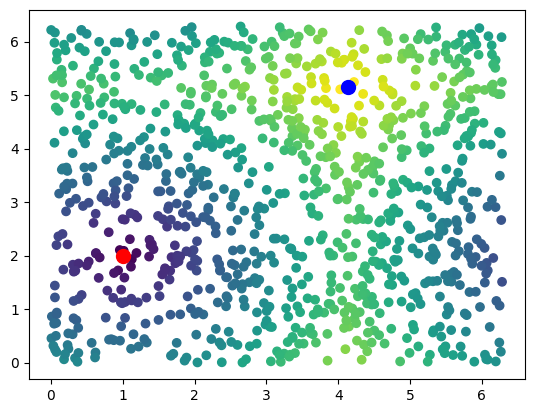

In [ ]:
def raw_kernel_estimate( )

7.346533677843928e-11


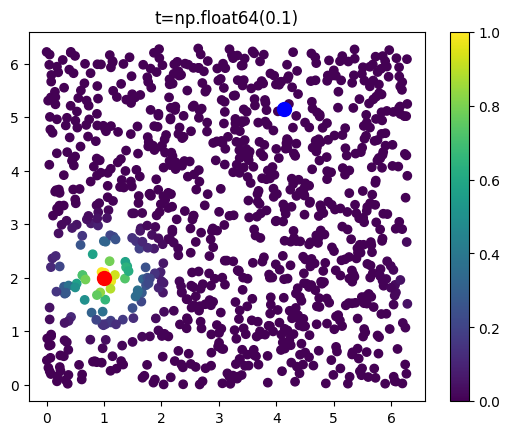

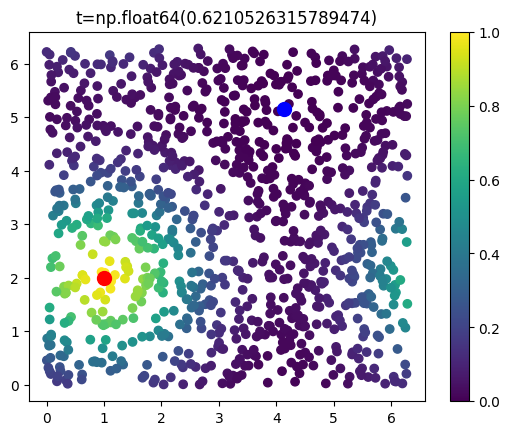

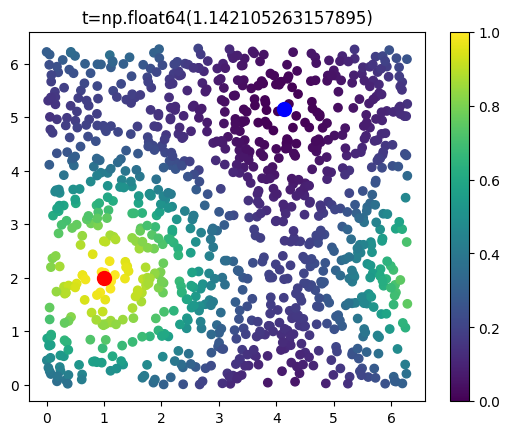

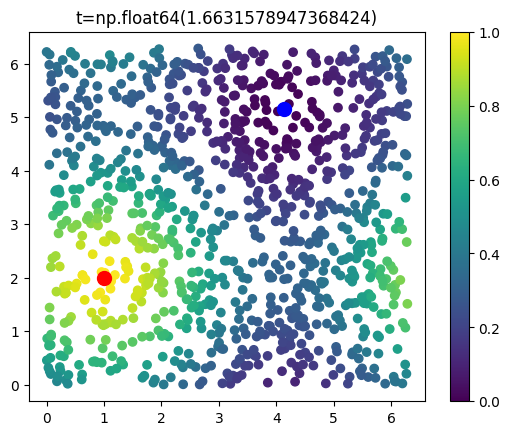

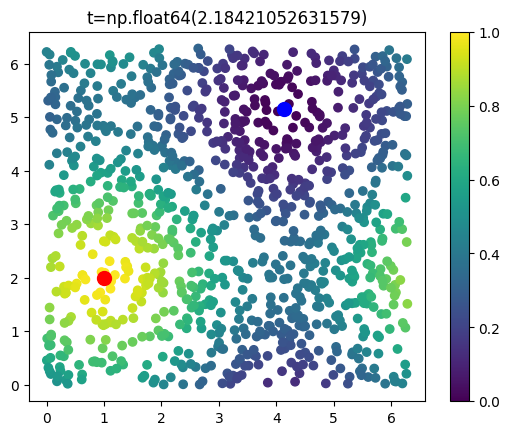

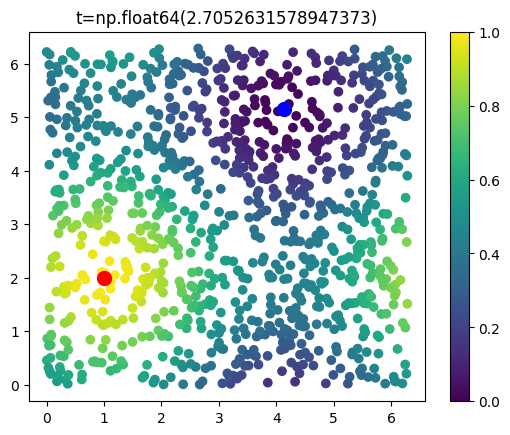

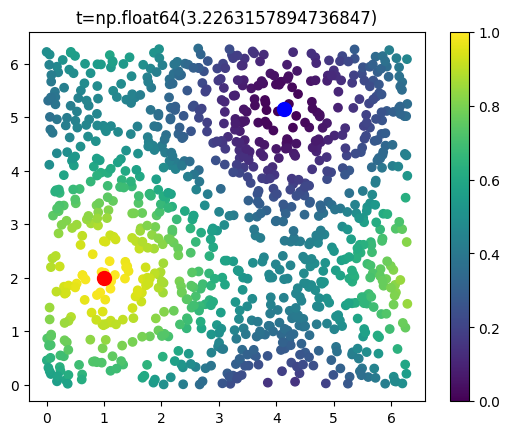

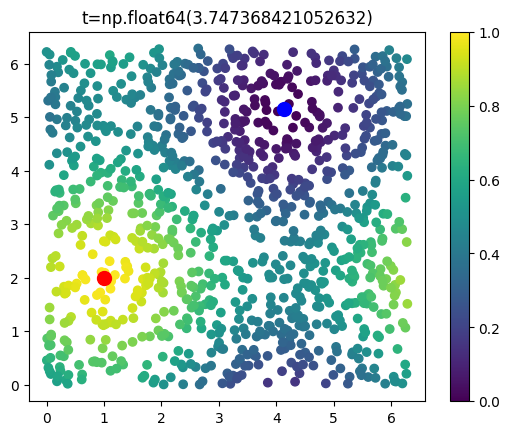

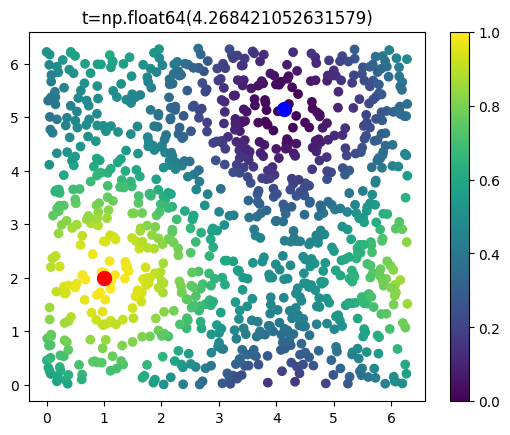

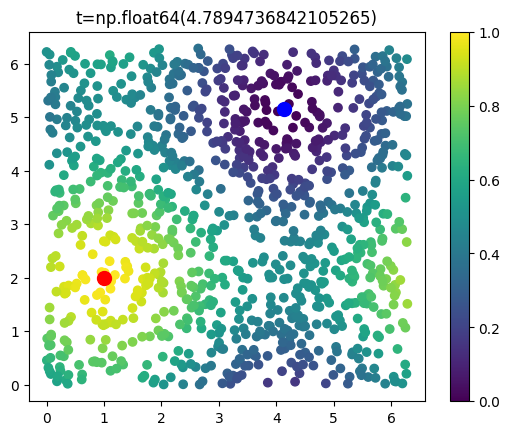

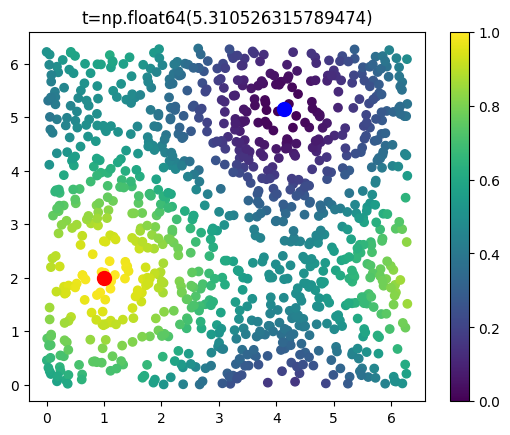

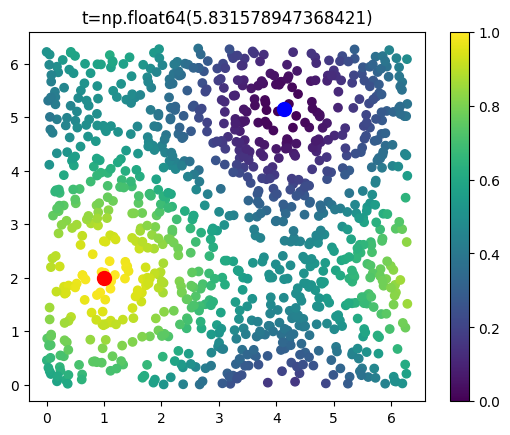

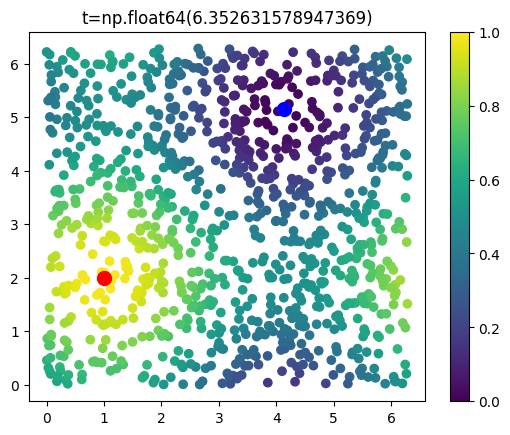

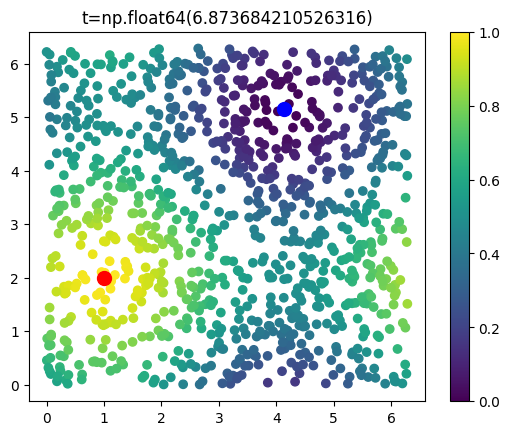

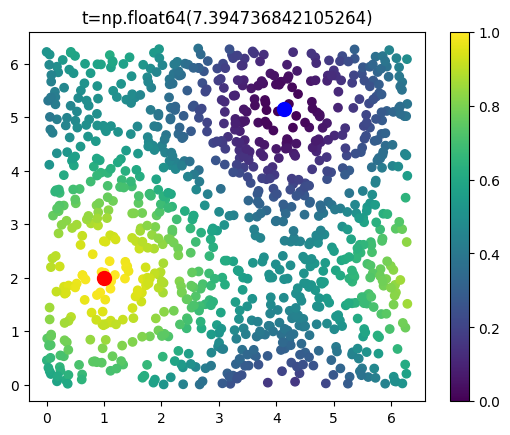

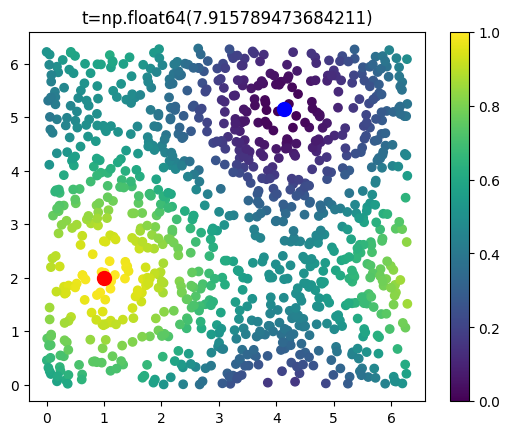

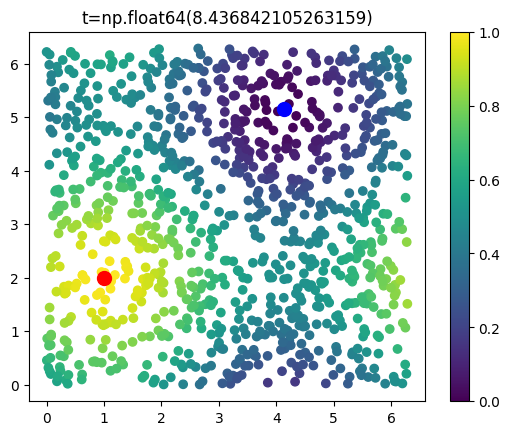

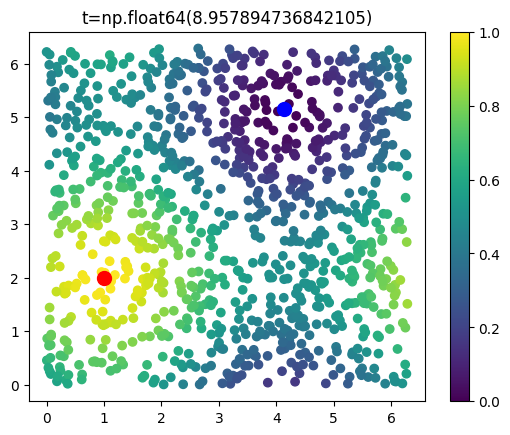

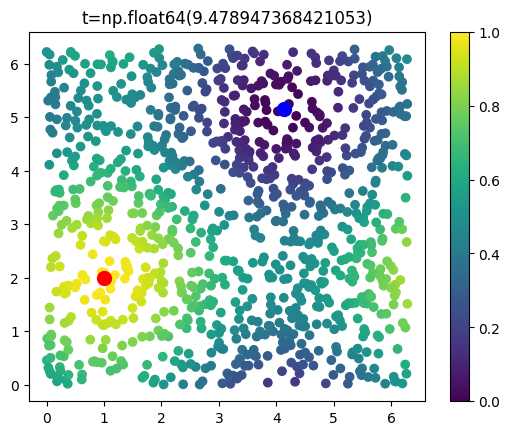

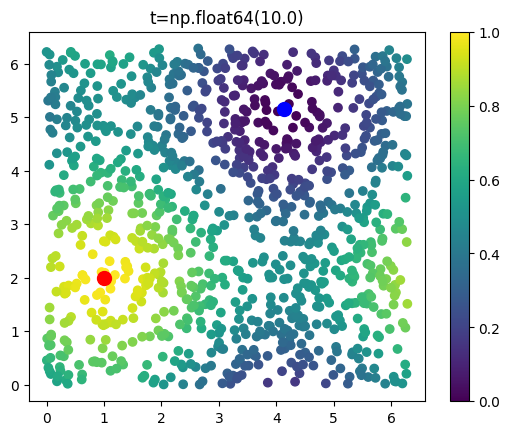

In [ ]:

for t in np.linspace(0.1, 10, num=20):
    origin_pt = p.cpu().numpy()
    ks = kernel_behaviour_near_origin(origin_pt, points, t=t)
    plt.scatter(points[:,0], points[:,1], c= ks)
    plt.scatter([origin_pt[0]], [origin_pt[1]], color='red', s=100)
    plt.scatter([np.pi + origin_pt[0]], [np.pi + origin_pt[1]], color='blue', s=100)
    plt.colorbar()
    plt.title(f'{t=}')
    plt.show()

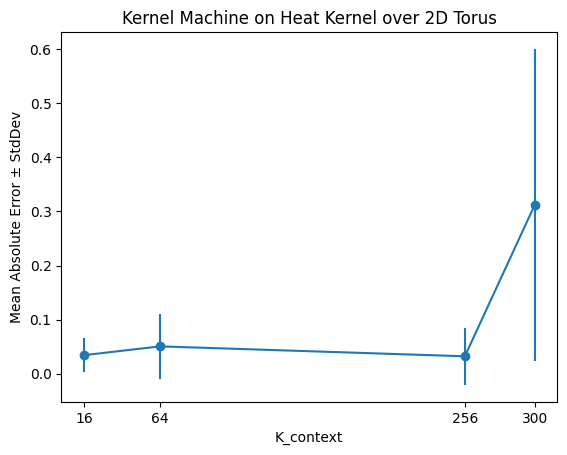

In [79]:
plt.errorbar(context_lengths, means, yerr=stds, fmt='-o')
plt.xlabel('K_context')
plt.ylabel('Mean Absolute Error ± StdDev')
plt.title('Kernel Machine on Heat Kernel over 2D Torus')
plt.xticks(context_lengths)
#plt.grid(True)
plt.show()  

In [ ]:
stds

array([0.8350578 , 1.04529741, 0.76512864, 0.77950387, 0.82112459,
       0.8005428 , 0.53565862])

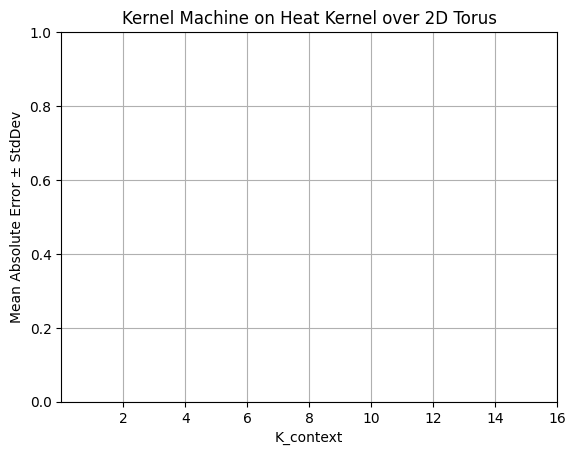

In [ ]:
#plt.errorbar(np.arange(2,18,2), means, yerr=stds, fmt='-o')
plt.xlabel('K_context')
plt.ylabel('Mean Absolute Error ± StdDev')
plt.title('Kernel Machine on Heat Kernel over 2D Torus')
plt.xticks(np.arange(2,18,2))
plt.grid(True)
plt.show() 